In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
from cvzone.HandTrackingModule import HandDetector
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
im_shape = (256, 256)
TRAINING_DIR = 'data/train5letras'
TEST_DIR = 'data/test5letras'

seed = 10

BATCH_SIZE = 32

In [3]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed, class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed, class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed, class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 6684 images belonging to 5 classes.
Found 1670 images belonging to 5 classes.
Found 2848 images belonging to 5 classes.
Classes: ['A', 'B', 'C', 'D', 'E']


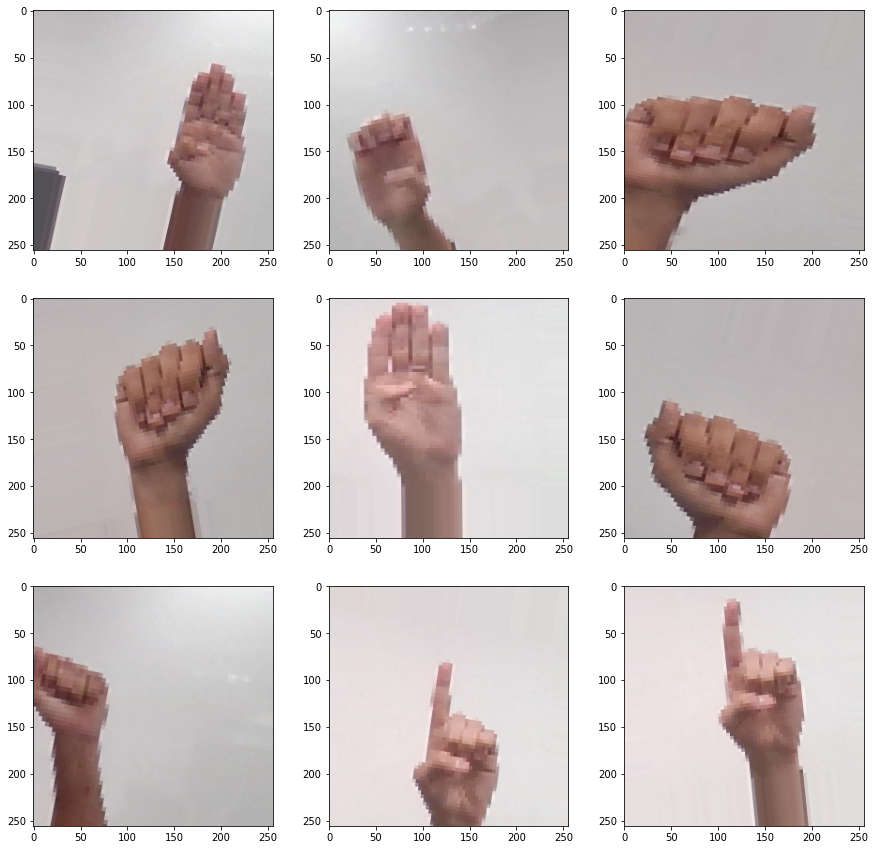

In [6]:
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                              

In [8]:
epochs = 200

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model/model5letras.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=30,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/200


2023-04-23 21:19:43.303613: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


208/208 [==============================] - ETA: 0s - loss: 1.6652 - accuracy: 0.2166
Epoch 1: val_loss improved from inf to 1.60971, saving model to model/model5letras.h5
208/208 [==============================] - 115s 545ms/step - loss: 1.6652 - accuracy: 0.2166 - val_loss: 1.6097 - val_accuracy: 0.1983
Epoch 2/200
208/208 [==============================] - ETA: 0s - loss: 1.6105 - accuracy: 0.1972
Epoch 2: val_loss improved from 1.60971 to 1.60945, saving model to model/model5letras.h5
208/208 [==============================] - 116s 556ms/step - loss: 1.6105 - accuracy: 0.1972 - val_loss: 1.6095 - val_accuracy: 0.2025
Epoch 3/200
202/208 [============================>.] - ETA: 3s - loss: 1.6099 - accuracy: 0.1926

KeyboardInterrupt: 

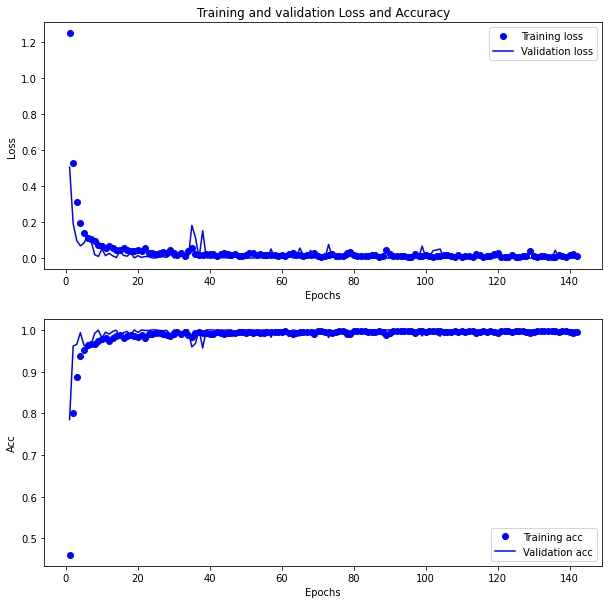

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model/model5letras.h5')

In [ ]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

53/53 [==============================] - 1s 21ms/step - loss: 2.3750e-09 - accuracy: 1.0000
Val loss: 2.3749819888507773e-09
Val accuracy: 1.0


In [ ]:
# Using the test dataset
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

89/89 [==============================] - 1s 16ms/step - loss: 1.3451e-07 - accuracy: 1.0000
Test loss: 1.345051998669078e-07
Test accuracy: 1.0


In [ ]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

89/89 [==============================] - 2s 15ms/step
Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       579
           B       1.00      1.00      1.00       562
           C       1.00      1.00      1.00       583
           D       1.00      1.00      1.00       550
           E       1.00      1.00      1.00       574

    accuracy                           1.00      2848
   macro avg       1.00      1.00      1.00      2848
weighted avg       1.00      1.00      1.00      2848



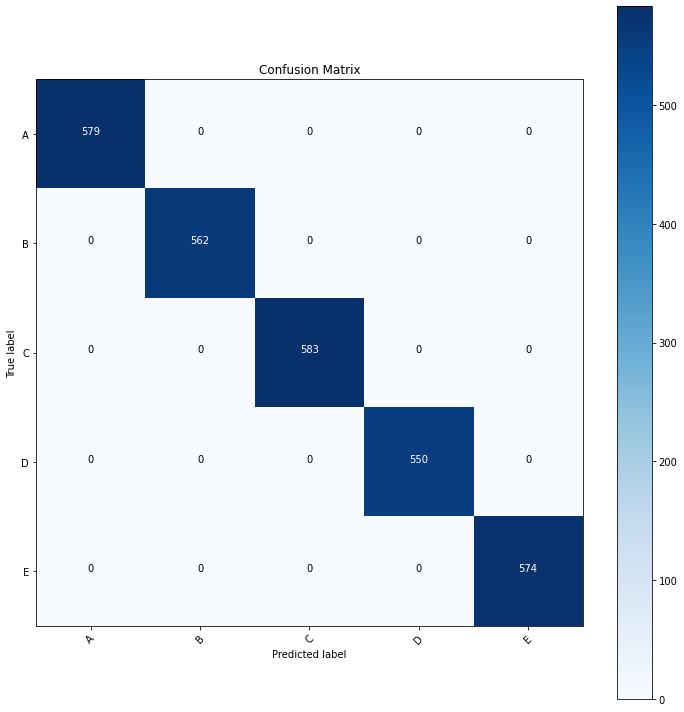

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [ ]:
class Classifier:
    
    def __init__(self, modelPath, labelsPath=None):
        self.model_path = modelPath
        # Disable scientific notation for clarity
        np.set_printoptions(suppress=True)
        # Load the model
        self.model = tensorflow.keras.models.load_model(self.model_path)

        # Create the array of the right shape to feed into the keras model
        # The 'length' or number of images you can put into the array is
        # determined by the first position in the shape tuple, in this case 1.
        self.data = np.ndarray(shape=(1, 256, 256, 3), dtype=np.float32)
        self.labels_path = labelsPath
        if self.labels_path:
            label_file = open(self.labels_path, "r")
            self.list_labels = []
            for line in label_file:
                stripped_line = line.strip()
                self.list_labels.append(stripped_line)
            label_file.close()
        else:
            print("No Labels Found")

    def getPrediction(self, img, draw= True, pos=(50, 50), scale=2, color = (0,255,0)):
        # resize the image to a 224x224 with the same strategy as in TM2:
#         imgS = cv2.resize(img, (256, 256))
        # turn the image into a numpy array
        image_array = np.asarray(img)
        # Normalize the image
        normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

        # Load the image into the array
        self.data[0] = img

        # run the inference
        prediction = self.model.predict(self.data)
        indexVal = np.argmax(prediction)
        print(prediction, indexVal)

        if draw and self.labels_path:
            cv2.putText(img, str(self.list_labels[indexVal]),
                        pos, cv2.FONT_HERSHEY_COMPLEX, scale, color, 2)

        return list(prediction[0]), indexVal

## Testando com a camera

In [ ]:
cap = cv2.VideoCapture(1)
detector = HandDetector(maxHands=1)

classifier = Classifier("model/model5letras.h5", "model/labels5letras.txt")

offset = 20
imgSize = 256

labels = ["A", "B", "C", "D", "E"]

while True:
    success, img = cap.read()
    imgOutput = img.copy()
    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand['bbox']

        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
        imgCrop = img[y - offset:y + h + offset, x - offset:x + w + offset]

        imgCropShape = imgCrop.shape

        aspectRatio = h / w

        if aspectRatio > 1:
            k = imgSize / h
            wCal = math.ceil(k * w)
            imgResize = cv2.resize(imgCrop, (wCal, imgSize))
            imgResizeShape = imgResize.shape
            wGap = math.ceil((imgSize - wCal) / 2)
            imgWhite[:, wGap:wCal + wGap] = imgResize
            resize = tf.image.resize(imgWhite, (256,256))
#             image = np.array(imgWhite)
            prediction, index = classifier.getPrediction(resize, draw=False)
#             print(prediction, index)

        else:
            k = imgSize / w
            hCal = math.ceil(k * h)
            imgResize = cv2.resize(imgCrop, (imgSize, hCal))
            imgResizeShape = imgResize.shape
            hGap = math.ceil((imgSize - hCal) / 2)
            imgWhite[hGap:hCal + hGap, :] = imgResize
            resize = tf.image.resize(imgWhite, (256,256))
#             image = np.array(imgWhite)
            prediction, index = classifier.getPrediction(resize, draw=False)

        cv2.rectangle(imgOutput, (x - offset, y - offset-50),
                      (x - offset+90, y - offset-50+50), (255, 0, 255), cv2.FILLED)
        cv2.putText(imgOutput, labels[index], (x, y -26), cv2.FONT_HERSHEY_COMPLEX, 1.7, (255, 255, 255), 2)
        cv2.rectangle(imgOutput, (x-offset, y-offset),
                      (x + w+offset, y + h+offset), (255, 0, 255), 4)


        cv2.imshow("ImageCrop", imgCrop)
        cv2.imshow("ImageWhite", imgWhite)

    cv2.imshow("Image", imgOutput)
    cv2.waitKey(1)

ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/librasenv/lib/python3.8/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/librasenv/lib/python3.8/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/librasenv/lib/python3.8/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/librasenv/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/librasenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/librasenv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 224, 224, 3)
